# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


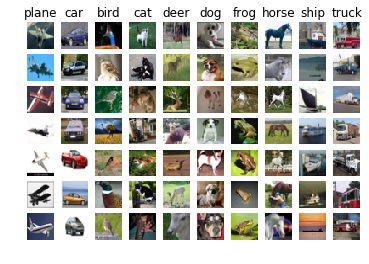

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


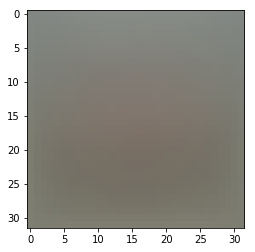

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.514164


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.274056 analytic: 4.354467, relative error: 9.319146e-03
numerical: -15.910491 analytic: -15.910491, relative error: 1.572161e-11
numerical: 22.175105 analytic: 22.175105, relative error: 8.274379e-12
numerical: 48.628224 analytic: 48.577750, relative error: 5.192500e-04
numerical: -5.642561 analytic: -5.654856, relative error: 1.088300e-03
numerical: -21.542171 analytic: -21.542171, relative error: 1.064569e-11
numerical: -6.543040 analytic: -6.543040, relative error: 1.447319e-10
numerical: -20.197293 analytic: -20.232169, relative error: 8.626434e-04
numerical: 27.909763 analytic: 27.909763, relative error: 1.626338e-11
numerical: 8.087372 analytic: 8.087372, relative error: 2.131343e-11
numerical: 7.656666 analytic: 7.656666, relative error: 6.486578e-11
numerical: 27.283378 analytic: 27.283378, relative error: 4.771089e-12
numerical: 4.031690 analytic: 4.031690, relative error: 8.409429e-11
numerical: 4.966518 analytic: 4.970837, relative error: 4.345916e-04
numerical:

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ The numerical gradient is usually the same as the analytical gradient for a linear function, as (f(x + h) - f(x)) / h essentially equals the slope. Howover, f(x) = max(0, x) introduces a hinge at x = 0. If the margin is negative and |margin| < |h|, the numerical gradient would not be equal to the analytical gradient (analytical = 0, numerical > 0 because f(margin + h) > 0). Increasing the margin could decrease the frequency of this happening by decreasing the chance of the margin being close to 0.


In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.514164e+00 computed in 0.194001s
Vectorized loss: 9.514164e+00 computed in 0.006031s
difference: 0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.228992s
Vectorized loss and gradient: computed in 0.006001s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [71]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 796.666207
iteration 100 / 1500: loss 290.651466
iteration 200 / 1500: loss 108.444456
iteration 300 / 1500: loss 43.070760
iteration 400 / 1500: loss 19.166640
iteration 500 / 1500: loss 10.225592
iteration 600 / 1500: loss 7.091835
iteration 700 / 1500: loss 6.115918
iteration 800 / 1500: loss 5.331093
iteration 900 / 1500: loss 5.136349
iteration 1000 / 1500: loss 5.538059
iteration 1100 / 1500: loss 5.332749
iteration 1200 / 1500: loss 4.825315
iteration 1300 / 1500: loss 5.062011
iteration 1400 / 1500: loss 5.062678
That took 9.533001s


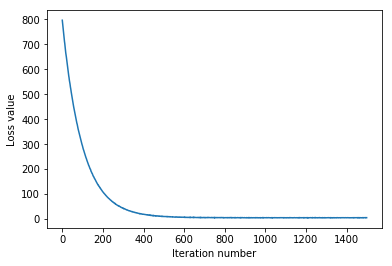

In [72]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [73]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.372367
validation accuracy: 0.387000


In [81]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-8, 1.7e-8, 3e-8, 5e-8, 1e-7, 1.7e-7, 3e-7, 5e-7, 1e-6, 1.7e-6]
regularization_strengths = [1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5]
# learning_rates = [1e-8, 3e-8, 1e-7, 3e-7, 1e-6]
# regularization_strengths = [3e3, 1e4, 3e4, 1e5, 3e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for rate in learning_rates:
    for strength in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=rate, reg=strength,
                      num_iters=2000, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print(train_accuracy)
        print(val_accuracy)
        print()
        results[(rate, strength)] = (train_accuracy, val_accuracy)
        if (val_accuracy > best_val):
            best_val = val_accuracy
            best_svm = svm
        # print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 24.793492
iteration 100 / 2000: loss 20.446302
iteration 200 / 2000: loss 20.610136
iteration 300 / 2000: loss 18.005414
iteration 400 / 2000: loss 15.484265
iteration 500 / 2000: loss 14.935493
iteration 600 / 2000: loss 15.258924
iteration 700 / 2000: loss 12.824545
iteration 800 / 2000: loss 14.564215
iteration 900 / 2000: loss 14.391740
iteration 1000 / 2000: loss 14.908528
iteration 1100 / 2000: loss 14.769415
iteration 1200 / 2000: loss 12.663956
iteration 1300 / 2000: loss 14.038490
iteration 1400 / 2000: loss 12.345234
iteration 1500 / 2000: loss 13.848693
iteration 1600 / 2000: loss 13.013683
iteration 1700 / 2000: loss 12.915055
iteration 1800 / 2000: loss 14.025730
iteration 1900 / 2000: loss 11.974611
0.23579591836734695
0.234

iteration 0 / 2000: loss 28.650879
iteration 100 / 2000: loss 25.157149
iteration 200 / 2000: loss 23.369220
iteration 300 / 2000: loss 21.374113
iteration 400 / 2000: loss 21.927845
iteration 500 / 2000: loss 20.983339
itera

iteration 1100 / 2000: loss 37.430639
iteration 1200 / 2000: loss 36.925626
iteration 1300 / 2000: loss 36.965964
iteration 1400 / 2000: loss 38.577478
iteration 1500 / 2000: loss 36.064335
iteration 1600 / 2000: loss 35.864024
iteration 1700 / 2000: loss 35.516357
iteration 1800 / 2000: loss 35.477409
iteration 1900 / 2000: loss 34.151042
0.24881632653061225
0.261

iteration 0 / 2000: loss 111.350881
iteration 100 / 2000: loss 106.812849
iteration 200 / 2000: loss 100.412512
iteration 300 / 2000: loss 99.197856
iteration 400 / 2000: loss 95.570713
iteration 500 / 2000: loss 92.487987
iteration 600 / 2000: loss 90.413060
iteration 700 / 2000: loss 88.052985
iteration 800 / 2000: loss 86.429489
iteration 900 / 2000: loss 84.652464
iteration 1000 / 2000: loss 83.588261
iteration 1100 / 2000: loss 80.125464
iteration 1200 / 2000: loss 79.483386
iteration 1300 / 2000: loss 79.093184
iteration 1400 / 2000: loss 76.760135
iteration 1500 / 2000: loss 74.921333
iteration 1600 / 2000: loss 73.7

iteration 200 / 2000: loss 461.772627
iteration 300 / 2000: loss 323.180769
iteration 400 / 2000: loss 226.995671
iteration 500 / 2000: loss 159.132335
iteration 600 / 2000: loss 111.965948
iteration 700 / 2000: loss 80.144757
iteration 800 / 2000: loss 57.254253
iteration 900 / 2000: loss 41.092806
iteration 1000 / 2000: loss 30.283651
iteration 1100 / 2000: loss 22.588920
iteration 1200 / 2000: loss 17.304350
iteration 1300 / 2000: loss 14.321206
iteration 1400 / 2000: loss 11.416378
iteration 1500 / 2000: loss 8.944509
iteration 1600 / 2000: loss 8.434809
iteration 1700 / 2000: loss 7.064160
iteration 1800 / 2000: loss 6.698538
iteration 1900 / 2000: loss 5.856474
0.3691632653061224
0.374

iteration 0 / 2000: loss 3122.719461
iteration 100 / 2000: loss 938.299312
iteration 200 / 2000: loss 284.513274
iteration 300 / 2000: loss 89.088795
iteration 400 / 2000: loss 30.359829
iteration 500 / 2000: loss 13.036050
iteration 600 / 2000: loss 8.190648
iteration 700 / 2000: loss 6.508991
it

iteration 1600 / 2000: loss 6.869168
iteration 1700 / 2000: loss 6.706793
iteration 1800 / 2000: loss 6.751629
iteration 1900 / 2000: loss 6.816075
0.3156326530612245
0.335

iteration 0 / 2000: loss 22.440705
iteration 100 / 2000: loss 15.715904
iteration 200 / 2000: loss 12.723666
iteration 300 / 2000: loss 11.489275
iteration 400 / 2000: loss 11.907857
iteration 500 / 2000: loss 9.252274
iteration 600 / 2000: loss 11.440155
iteration 700 / 2000: loss 9.619832
iteration 800 / 2000: loss 10.563337
iteration 900 / 2000: loss 10.254746
iteration 1000 / 2000: loss 10.096534
iteration 1100 / 2000: loss 10.913964
iteration 1200 / 2000: loss 9.690695
iteration 1300 / 2000: loss 8.725179
iteration 1400 / 2000: loss 9.958731
iteration 1500 / 2000: loss 8.661013
iteration 1600 / 2000: loss 9.090207
iteration 1700 / 2000: loss 8.864078
iteration 1800 / 2000: loss 9.127096
iteration 1900 / 2000: loss 8.874645
0.31351020408163266
0.319

iteration 0 / 2000: loss 32.844529
iteration 100 / 2000: loss

iteration 1000 / 2000: loss 20.359624
iteration 1100 / 2000: loss 18.569622
iteration 1200 / 2000: loss 17.528916
iteration 1300 / 2000: loss 16.765408
iteration 1400 / 2000: loss 15.813076
iteration 1500 / 2000: loss 15.893070
iteration 1600 / 2000: loss 14.253065
iteration 1700 / 2000: loss 14.384307
iteration 1800 / 2000: loss 12.909655
iteration 1900 / 2000: loss 12.635228
0.36612244897959184
0.375

iteration 0 / 2000: loss 112.310276
iteration 100 / 2000: loss 83.692811
iteration 200 / 2000: loss 67.794930
iteration 300 / 2000: loss 56.664261
iteration 400 / 2000: loss 45.244958
iteration 500 / 2000: loss 38.186704
iteration 600 / 2000: loss 30.921360
iteration 700 / 2000: loss 26.248140
iteration 800 / 2000: loss 22.442018
iteration 900 / 2000: loss 18.728702
iteration 1000 / 2000: loss 16.049794
iteration 1100 / 2000: loss 14.300583
iteration 1200 / 2000: loss 12.404828
iteration 1300 / 2000: loss 10.736120
iteration 1400 / 2000: loss 9.159915
iteration 1500 / 2000: loss 8.81237

iteration 500 / 2000: loss 6.269589
iteration 600 / 2000: loss 5.351710
iteration 700 / 2000: loss 5.988976
iteration 800 / 2000: loss 5.688144
iteration 900 / 2000: loss 5.796075
iteration 1000 / 2000: loss 5.200525
iteration 1100 / 2000: loss 5.370199
iteration 1200 / 2000: loss 5.690580
iteration 1300 / 2000: loss 5.743284
iteration 1400 / 2000: loss 5.541028
iteration 1500 / 2000: loss 5.889804
iteration 1600 / 2000: loss 5.218379
iteration 1700 / 2000: loss 5.573973
iteration 1800 / 2000: loss 5.489656
iteration 1900 / 2000: loss 5.598620
0.3500408163265306
0.358

iteration 0 / 2000: loss 3108.728258
iteration 100 / 2000: loss 6.003775
iteration 200 / 2000: loss 6.318821
iteration 300 / 2000: loss 6.868594
iteration 400 / 2000: loss 6.084407
iteration 500 / 2000: loss 7.027778
iteration 600 / 2000: loss 6.586903
iteration 700 / 2000: loss 6.218794
iteration 800 / 2000: loss 6.399277
iteration 900 / 2000: loss 6.392572
iteration 1000 / 2000: loss 6.634400
iteration 1100 / 2000: los

iteration 100 / 2000: loss 11.542054
iteration 200 / 2000: loss 9.381457
iteration 300 / 2000: loss 9.116345
iteration 400 / 2000: loss 8.182186
iteration 500 / 2000: loss 7.906651
iteration 600 / 2000: loss 8.632650
iteration 700 / 2000: loss 8.170423
iteration 800 / 2000: loss 7.139684
iteration 900 / 2000: loss 6.824731
iteration 1000 / 2000: loss 6.297108
iteration 1100 / 2000: loss 6.962760
iteration 1200 / 2000: loss 6.563920
iteration 1300 / 2000: loss 6.505331
iteration 1400 / 2000: loss 5.564674
iteration 1500 / 2000: loss 6.295205
iteration 1600 / 2000: loss 6.745414
iteration 1700 / 2000: loss 6.053053
iteration 1800 / 2000: loss 5.734003
iteration 1900 / 2000: loss 6.349925
0.38816326530612244
0.362

iteration 0 / 2000: loss 33.982274
iteration 100 / 2000: loss 15.353054
iteration 200 / 2000: loss 11.811498
iteration 300 / 2000: loss 12.053447
iteration 400 / 2000: loss 10.319076
iteration 500 / 2000: loss 9.702857
iteration 600 / 2000: loss 8.459072
iteration 700 / 2000: l

iteration 1800 / 2000: loss 7.349916
iteration 1900 / 2000: loss 6.098833
0.3119795918367347
0.31

iteration 0 / 2000: loss 116.009618
iteration 100 / 2000: loss 19.807157
iteration 200 / 2000: loss 7.946087
iteration 300 / 2000: loss 7.602100
iteration 400 / 2000: loss 6.875146
iteration 500 / 2000: loss 6.995470
iteration 600 / 2000: loss 7.658675
iteration 700 / 2000: loss 7.143538
iteration 800 / 2000: loss 5.849832
iteration 900 / 2000: loss 7.340807
iteration 1000 / 2000: loss 7.056385
iteration 1100 / 2000: loss 6.162157
iteration 1200 / 2000: loss 5.687812
iteration 1300 / 2000: loss 6.678086
iteration 1400 / 2000: loss 6.565181
iteration 1500 / 2000: loss 7.518364
iteration 1600 / 2000: loss 6.443134
iteration 1700 / 2000: loss 7.703988
iteration 1800 / 2000: loss 6.602149
iteration 1900 / 2000: loss 6.960936
0.3419387755102041
0.342

iteration 0 / 2000: loss 327.262405
iteration 100 / 2000: loss 9.536748
iteration 200 / 2000: loss 7.655909
iteration 300 / 2000: loss 8.223718


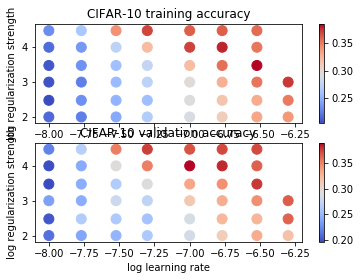

In [80]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [76]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.370000


In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

#### **Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ Many of the visualized weights almost seem to represent the labels themselves. This is because they are tuned by the training set such that they can generate the maximum scores for objects that match the weights but minimum scores for other objects. Their most prominent features, then represent the most prominent features of the images they were trained with (so the pixel magnitudes of these prominent features can be multiplied together to generate a higher score).
